Install and load packages

In [117]:
!pip install shap -qq
!pip install sweetviz -qq
!pip install line_profiler
!pip install memory_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [152]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import lasso_path
import xgboost
import shap
import urllib.request
import gzip
import sweetviz as sv
from sklearn.model_selection import train_test_split

Download data

In [153]:
'''Wybrałam 3 miasta jak poniżej, aby zmienić miasto jakie ten plik 
analizuje zakomentujcie inny URL_SOURCE'''

#city listing summary adress url

'''Sevilla'''
#URL_SOURCE = 'http://data.insideairbnb.com/spain/andaluc%C3%ADa/sevilla/2022-09-26/data/listings.csv.gz'

'''Athens'''
#URL_SOURCE = 'http://data.insideairbnb.com/greece/attica/athens/2022-09-20/data/listings.csv.gz'

'''Florence'''
URL_SOURCE = 'http://data.insideairbnb.com/italy/toscana/florence/2022-09-14/data/listings.csv.gz'

#download file
urllib.request.urlretrieve(URL_SOURCE, 'listings.csv.gz')

#open file csv.gz and read
with gzip.open('listings.csv.gz', 'rb') as f:
    file_content = f.read()

with open('sevilla_listings.csv', 'wb') as f:
    f.write(file_content)

In [154]:
'''Wczytywanie do ramki danych całego pliku, wszystkich kolumn'''
#read data into dataframe
data_frame = pd.read_csv('sevilla_listings.csv')
data_frame.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11138 entries, 0 to 11137
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            11138 non-null  int64  
 1   listing_url                                   11138 non-null  object 
 2   scrape_id                                     11138 non-null  int64  
 3   last_scraped                                  11138 non-null  object 
 4   source                                        11138 non-null  object 
 5   name                                          11136 non-null  object 
 6   description                                   10979 non-null  object 
 7   neighborhood_overview                         6849 non-null   object 
 8   picture_url                                   11138 non-null  object 
 9   host_id                                       11138 non-null 

Basic report

In [121]:
'''Generowanie raportu, jak nie wyskoczy w nowym oknie 
to trzeba go sobie pobrać z plików na dysku, jest zapisany jako SWEETVIZ_REPORT'''

report = sv.analyze(data_frame, pairwise_analysis='off')
report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Select atributes

In [155]:
'''Wstępny wybór kolumn do analizy'''

selected_columns = ['price','bathrooms_text','accommodates','bedrooms','review_scores_cleanliness', 'amenities']
#and check their types
data_frame[selected_columns].dtypes

price                         object
bathrooms_text                object
accommodates                   int64
bedrooms                     float64
review_scores_cleanliness    float64
amenities                     object
dtype: object

In [156]:
'''Jak to mniej więcej wygląda, bierzemy bathrooms_text bo kolumna bathrooms jest pusta,
potem wyciągniemy sobie liczby'''
data_frame[selected_columns].describe
data_frame[selected_columns].head()

,price,bathrooms_text,accommodates,bedrooms,review_scores_cleanliness,amenities
0,$260.00,1 private bath,4,2.0,4.71,"[""Host greets you"", ""Air conditioning"", ""Wifi""..."
1,$95.00,1 bath,4,2.0,5.00,"[""Air conditioning"", ""Wifi"", ""Long term stays ..."
2,$100.00,1 private bath,3,1.0,4.50,"[""Cleaning products"", ""Wifi"", ""Mosquito net"", ..."
3,$80.00,1 private bath,1,1.0,5.00,"[""Wifi"", ""Private entrance"", ""Long term stays ..."
4,$80.00,1 private bath,2,1.0,4.92,"[""Wifi"", ""Crib"", ""Mosquito net"", ""Hot water"", ..."


In [157]:
'''Sprawdzamy braki'''
#check missing values
data_frame[selected_columns].isna().sum()

price                           0
bathrooms_text                  9
accommodates                    0
bedrooms                      346
review_scores_cleanliness    1583
amenities                       0
dtype: int64

In [158]:
'''Usuwamy braki i zapisujemy wybrane kolumny w nowej DataFrame'''
#remove NaN values
data = data_frame[selected_columns].dropna()
data.head()

,price,bathrooms_text,accommodates,bedrooms,review_scores_cleanliness,amenities
0,$260.00,1 private bath,4,2.0,4.71,"[""Host greets you"", ""Air conditioning"", ""Wifi""..."
1,$95.00,1 bath,4,2.0,5.00,"[""Air conditioning"", ""Wifi"", ""Long term stays ..."
2,$100.00,1 private bath,3,1.0,4.50,"[""Cleaning products"", ""Wifi"", ""Mosquito net"", ..."
3,$80.00,1 private bath,1,1.0,5.00,"[""Wifi"", ""Private entrance"", ""Long term stays ..."
4,$80.00,1 private bath,2,1.0,4.92,"[""Wifi"", ""Crib"", ""Mosquito net"", ""Hot water"", ..."


In [159]:
'''Rozkładamy amenities na osobne klumny z wartością True lub False w zależności czy
w stringu występuje to słowo czy nie'''

#remove "" 
data.amenities = data_frame.amenities.apply(lambda x: x.replace('"',''))

#select interesting attributes form 'amenities' column
list_amenities = ['Air conditioning', 'Wifi', 'Kitchen', 'Microwave',
                  'Refrigerator', 'Iron', 'Full kitchen', 'Coffee maker',
                  'Dryer', 'Shared garden or backyard', 'Washer', 'Breakfast', 
                  'Toaster', 'Wine glasses', 'Dishwasher', 'Shared pool']

def separateAmenities(record):
  '''#slice each into a separate column, 
  add label True or False, change type to bool
  '''
  data[f"{record}"] = ''
  for index, row in data.iterrows():
    if f'{record}' in row.amenities:
      data.at[index, f'{record}'] = True
    else:
      data.at[index, f'{record}'] = False
    data[f'{record}'] = data[f'{record}'].astype(bool)

for each in list_amenities:
  separateAmenities(each)

#examine our function separateAmenities
%load_ext line_profiler
%load_ext memory_profiler

#%lprun -f separateAmenities separateAmenities(each)
%mprun -f separateAmenities separateAmenities(each)




The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
ERROR: Could not find file <ipython-input-159-503a7fd7bca6>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.



In [160]:
'''Trochę ręcznych porządków, bo nie możemy mieć spacji w nazwie kolumny'''

#remove ' ' from column name
data.rename(columns={'Air conditioning': 'Air_conditioning',
                     'Shared garden or backyard': 'Shared_garden_or_backyard',
                     'Coffee maker': 'Coffee_maker',
                     'Full kitchen': 'Full_kitchen',
                     'Wine glasses': 'Wine_glasses',
                     'Shared pool': 'Shared_pool'}, inplace=True)
variables = list(data.columns)
variables

['price',
 'bathrooms_text',
 'accommodates',
 'bedrooms',
 'review_scores_cleanliness',
 'amenities',
 'Air_conditioning',
 'Wifi',
 'Kitchen',
 'Microwave',
 'Refrigerator',
 'Iron',
 'Full_kitchen',
 'Coffee_maker',
 'Dryer',
 'Shared_garden_or_backyard',
 'Washer',
 'Breakfast',
 'Toaster',
 'Wine_glasses',
 'Dishwasher',
 'Shared_pool']

In [161]:
'''Wrzucamy price jako float'''
#cast price as float
data.price = data.price.apply(lambda x: x.replace('$',''))
data.price = data.price.apply(lambda x: x.replace(',',''))
data.price = pd.to_numeric(data.price, errors='coerce')
data.price.describe()

count    9254.000000
mean      157.400800
std       269.224413
min        10.000000
25%        72.000000
50%       107.000000
75%       170.000000
max      9223.000000
Name: price, dtype: float64

In [178]:
'''Tu ważne, odpalcie sobie tyle razy tą komórkę, żeby wartość "99,5% properties..."
była zbliżona do std z góry, albo trochę większa, np. 300, 350, ale nie 1000, 
bo to potem psuje OLS'''

# Getting rid of outliers
print("99.5% properties have a price lower than {0: .2f}".format(np.percentile(data.price, 99.5)))
data = data[(data.price <= np.percentile(data.price, 99.5)) & (data.price > 0)]

99.5% properties have a price lower than  314.27


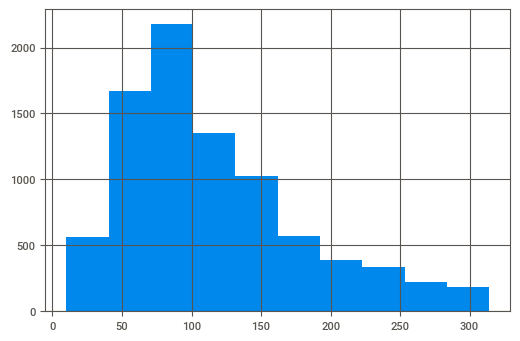

In [179]:
data.price.hist()

In [180]:
'''Sprawdzamy jakie mamy rodzaje łazienek w zbiorze'''

#replace number of bathrooms and change to int
data.bathrooms_text.unique()

array(['1 private bath', '1 bath', '1 shared bath', '2 baths',
       '1.5 baths', '3 baths', '2.5 baths', '0 baths', '2 shared baths',
       '1.5 shared baths', '6 baths', 'Half-bath', '4 baths', '3.5 baths',
       'Shared half-bath', '3 shared baths', '5 baths', '0 shared baths',
       '2.5 shared baths', 'Private half-bath'], dtype=object)

In [181]:
'''Odrzucamy niektóre np. half-bath, shared baths, no tak, 
żeby mieć w miarę jednorodny typ łazienek do analizy, różniący się ich liczbą,
dalej wyrzucamy z kolumny bathrooms_text te, których nie chcemy'''

#take unique values from column bathrooms_text
bathrooms_options_list = ['1 bath','1.5 baths','2 baths',
                          '3 baths','3.5 baths','2.5 baths','4 baths','5 baths',
                          '7.5 baths', '6 baths', '4.5 baths','5.5 baths',
                          '15.5 baths','6.5 baths', '13.5 baths', '7 baths', '0 baths']

#drop rows with values different than in list above
data.drop(data[~data['bathrooms_text'].isin(bathrooms_options_list)].index, inplace=True)


In [182]:
'''Slajsujemy test i pakujemy wartość liczbową do kolumny bathrooms_number'''

#get numbers from column bathroom_text
data[['bathrooms_number','bathrooms_text2']] = data.bathrooms_text.str.split('b',expand=True)
data.drop('bathrooms_text2', inplace=True, axis=1)
data.bathrooms_number.unique()

array(['1 ', '2 ', '1.5 ', '3 ', '2.5 ', '0 ', '6 ', '4 ', '3.5 ', '5 '],
      dtype=object)

In [183]:
'''Robimy w bathrooms_number homogeniczne wartości typu float'''

#save column bathroom_number as float
data.bathrooms_number = data.bathrooms_number.astype(float)
data.head()

,price,bathrooms_text,accommodates,bedrooms,review_scores_cleanliness,amenities,Air_conditioning,Wifi,Kitchen,Microwave,...,Coffee_maker,Dryer,Shared_garden_or_backyard,Washer,Breakfast,Toaster,Wine_glasses,Dishwasher,Shared_pool,bathrooms_number
1,95.0,1 bath,4,2.0,5.00,"[Air conditioning, Wifi, Long term stays allow...",True,True,False,False,...,False,True,False,False,False,False,False,False,False,1.0
7,75.0,1 bath,4,1.0,4.93,"[Cleaning products, Wifi, Barbecue utensils, C...",False,True,True,True,...,True,False,True,False,False,True,False,True,False,1.0
10,224.0,1 bath,6,2.0,4.58,"[Wifi, Crib, Hot water, Iron, TV with standard...",True,True,True,True,...,True,False,False,True,False,False,False,False,False,1.0
11,60.0,2 baths,10,2.0,4.29,"[Wifi, Private entrance, Long term stays allow...",False,True,True,False,...,False,False,False,True,False,False,False,False,False,2.0
12,180.0,2 baths,8,2.0,5.00,"[Baby bath, Wifi, Changing table, Hot water, F...",False,True,True,True,...,True,False,False,False,False,False,True,True,False,2.0


Modelling

In [184]:
'''Modelujemy, to co zakomentowane miało ujemny lub znikomy wpływ
 na kształtowanie modelu, wysokie "p" itd'''
 
model = smf.ols('price ~ accommodates + review_scores_cleanliness +' 
                'bathrooms_number + Wifi + Air_conditioning +' 
                #Microwave + bedrooms + Toaster + Refrigerator + Kitchen + Shared_garden_or_backyard + Coffee_maker + Washer + Breakfast + Wine_glasses
                'Iron + Full_kitchen + Dryer +' 
                'Air_conditioning +' 
                'Dishwasher + Shared_pool', data=data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     182.5
Date:                Wed, 04 Jan 2023   Prob (F-statistic):               0.00
Time:                        19:13:05   Log-Likelihood:                -37691.
No. Observations:                6923   AIC:                         7.540e+04
Df Residuals:                    6912   BIC:                         7.548e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

Lasso

(0.0007089916900792422,
 38.17456879911067,
 -1.571947840305085,
 14.547299045636986)

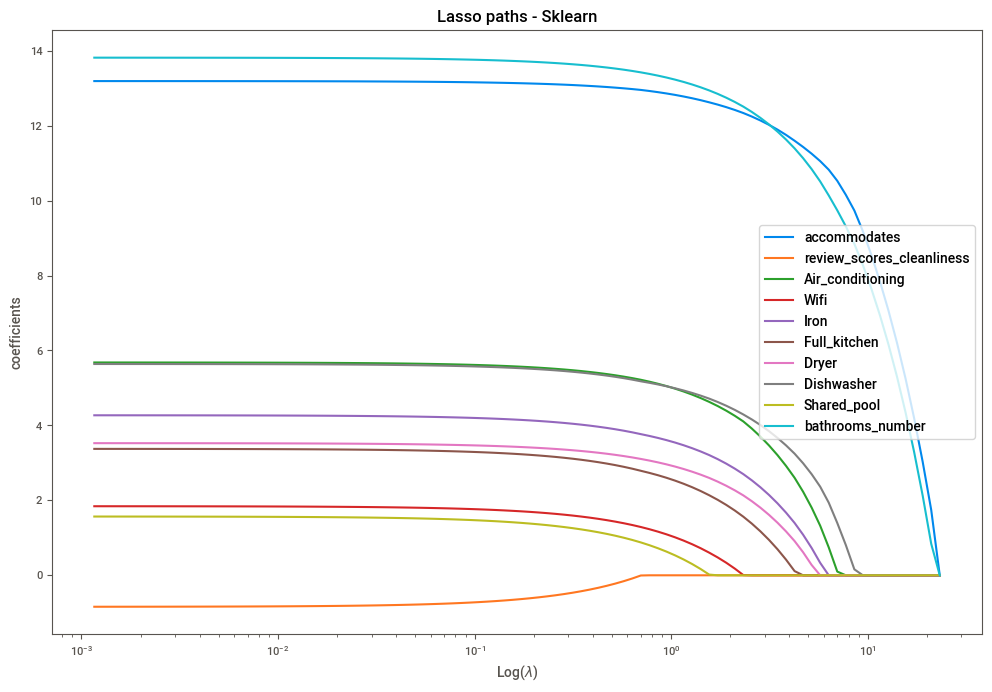

In [185]:
'''Tu te same wartości co powyżej i też wycięte te mniej istotne'''

variables = [
 'accommodates',
 #'bedrooms',
 'review_scores_cleanliness',
 'Air_conditioning',
 'Wifi',
 #'Kitchen',
 #'Microwave',
 #'Refrigerator',
 'Iron',
 'Full_kitchen',
 #'Coffee_maker',
 'Dryer',
 #'Shared_garden_or_backyard',
 #'Washer',
 #'Breakfast',
 #'Toaster',
 #'Wine_glasses',
 'Dishwasher',
 'Shared_pool',
 'bathrooms_number']

data_subset = data.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)

X = data_subset.loc[:,variables]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = variables[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

xgBoost

In [186]:
'''XGBoost z wydzielonymi zbiorami treningowymi i testowymi'''

# XGBoost

#variables = ['accommodates', 'bedrooms', 'bathrooms_number', 'review_scores_cleanliness', 'Wifi', 'Air_conditioning', 'Kitchen', 'Microwave']
data_subset = data.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:100000,:]

X = data_subset.loc[:,variables]
#X = preprocessing.scale(X) #We don't have to scale it as trees don't care about distributions, means, and all that smart stuff
y = np.array(data_subset.price)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = xgboost.XGBRegressor(n_estimators=1000, verbosity=1)
model.fit(X_train, y_train)

[19:14:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

In [187]:
predicted = model.predict(X_test)
mean_squared_error(y_test, predicted)

3163.3928459872623

Ceteris paribus

[19:14:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


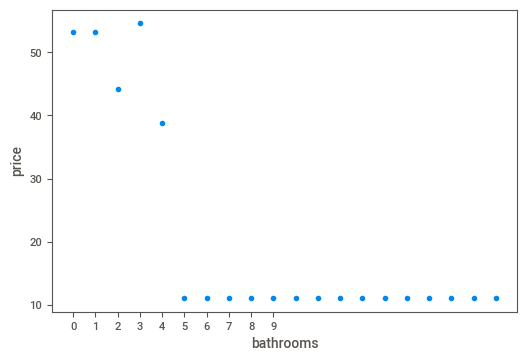

In [188]:
# Simpler example

data_temp = pd.DataFrame({"bathrooms_number" : [x for x in range(20)]})
#data_temp['review_scores_cleanliness'] = 5


#data_temp['number_of_reviews'] = 100

variables = [
 'accommodates',
 #'bedrooms',
 'review_scores_cleanliness',
 'Air_conditioning',
 'Wifi',
 #'Kitchen',
 #'Microwave',
 #'Refrigerator',
 'Iron',
 'Full_kitchen',
 #'Coffee_maker',
 'Dryer',
 #'Shared_garden_or_backyard',
 #'Washer',
 #'Breakfast',
 #'Toaster',
 #'Wine_glasses',
 'Dishwasher',
 'Shared_pool',
 'bathrooms_number']
#variables = ['bathrooms_number']#, 'number_of_reviews']
data_subset = data.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:10000,:]
X = data_subset.loc[:,variables]
#X = preprocessing.scale(X) #We don't have to scale it as trees don't care about distributions, means, and all that smart stuff
y = np.array(data_subset.price)
model = xgboost.XGBRegressor(n_estimators=100, verbosity=1, random_state=7)
model.fit(X, y)

#We need to reindex, because xgboost is an annoyance 
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)

#Predict
predictions_temp = model.predict(data_temp)

#Plot
plt.scatter(x=data_temp.bathrooms_number, y=predictions_temp)
plt.xlabel('bathrooms')
plt.ylabel('price')
plt.xticks(range(10))
plt.show()

Shapley

In [189]:
#Playing with Shapley values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [190]:
X.iloc[0,:]

accommodates                     4
review_scores_cleanliness      5.0
Air_conditioning              True
Wifi                          True
Iron                         False
Full_kitchen                 False
Dryer                         True
Dishwasher                   False
Shared_pool                  False
bathrooms_number               1.0
Name: 1, dtype: object

In [191]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

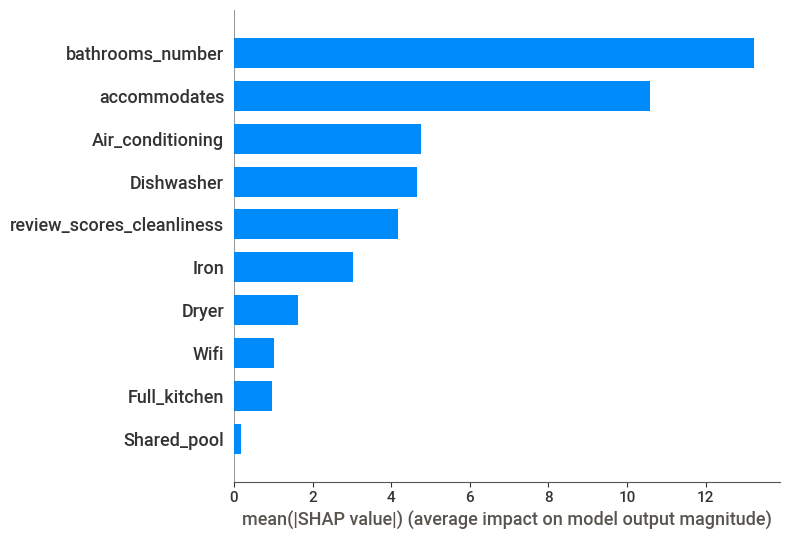

In [192]:
shap.summary_plot(shap_values, X, plot_type="bar")

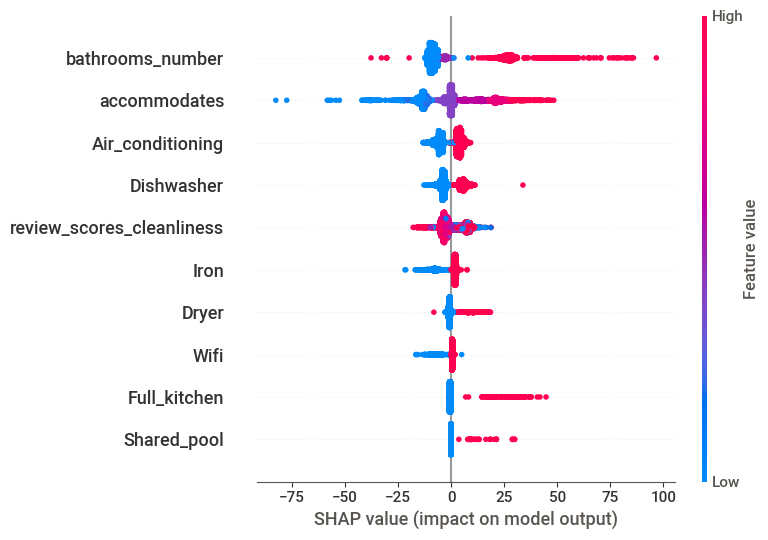

In [193]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)